<a href="https://colab.research.google.com/github/nguobadia/Kangaroo-Mask-RCNN/blob/master/Kangaroo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask RCNN Tutorial and Demo


In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/My Drive/Colab Notebooks/kangaroo.zip" -d "/content/drive/My Drive/Colab Notebooks"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# imports
from sys import path
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline
import random

path.insert(1, 'Mask_RCNN/')
from mrcnn.config import Config
from mrcnn.utils import Dataset, compute_ap, extract_bboxes
from mrcnn.model import load_image_gt, mold_image, MaskRCNN
from mrcnn.visualize import display_instances

## `KangarooDataset(Dataset)`
This class is a child from the dataset class in the `mrcnn` module.

In [0]:
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
  
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
  
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
   
			# skip bad images
			if image_id in ['00090']:
				continue

			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue

			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue

			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
   
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
  
		# get the root of the document
		root = tree.getroot()
  
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
   
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
  
		# define box file location
		path = info['annotation']
  
		# load XML
		boxes, w, h = self.extract_boxes(path)
  
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
  
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
   
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

    

## `KangarooConfig(Config)`
This class houses the configuration data for a dataset, particularly for our `KangarooDataset`.

In [0]:
# define a configuration for the model
class KangarooConfig(Config):
	# Give the configuration a recognizable name
	NAME = "kangaroo_cfg"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 131

Below checks to make sure that the dataset was loaded in correctly, which it seemingly does.

In [0]:
# prepare train set
train_set = KangarooDataset()
colab_path = '/content/drive/My Drive/Colab Notebooks/'
train_set.load_dataset(colab_path + 'kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset(colab_path + 'kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 131
Test: 32


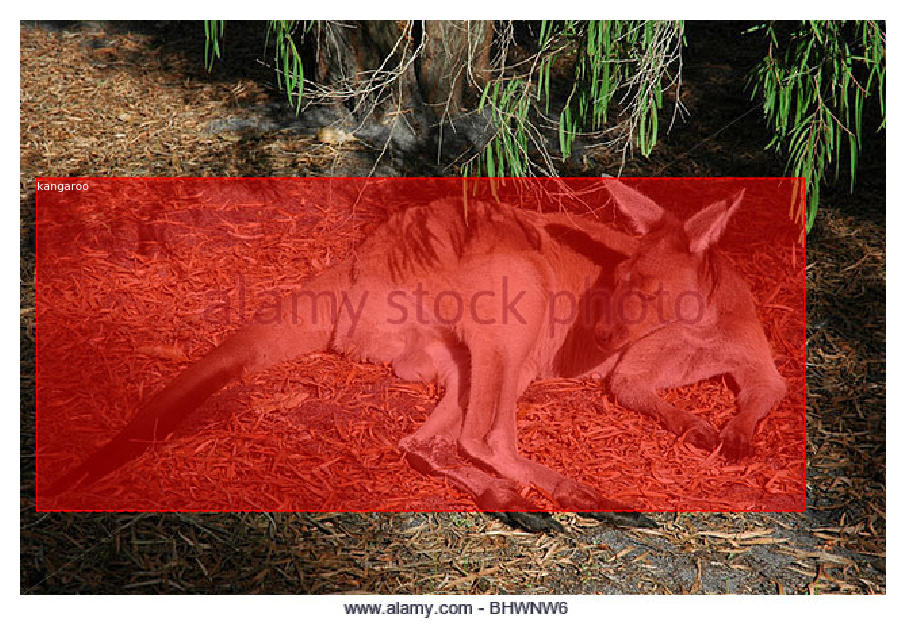

In [0]:
# train set
train_set = KangarooDataset()
train_set.load_dataset(colab_path + 'kangaroo', is_train=True)
train_set.prepare()

# picks a random image ID from a list of possible image ID's
image_id = random.choice(list(range(1,131)))

# load the image
image = train_set.load_image(image_id)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)

# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Training done in Google Colab

In [0]:
# prepare config
config = KangarooConfig()
config.display()

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# load weights (mscoco) and exclude the output layers
model.load_weights(colab_path + 'mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
131/131 [==============================] - 164s 1s/step - loss: 0.9674 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.3471 - mrcnn_mask_loss: 0.3682 - val_loss: 0.7416 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.1901 - val_mrcnn_class_loss: 0.0299 - val_mrcnn_bbox_loss: 0.2557 - val_mrcnn_mask_loss: 0.2588

Epoch 2/5
131/131 [==============================] - 96s 731ms/step - loss: 0.5393 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.2352 - val_loss: 0.8273 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.3628 - val_mrcnn_class_loss: 0.0321 - val_mrcnn_bbox_loss: 0.1860 - val_mrcnn_mask_loss: 0.2347
Epoch 3/5
131/131 [==============================] - 97s 742ms/step - loss: 0.4419 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2146 - val_loss: 0.8257 - val_rpn_cla

## Evaluating the model

In [0]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
    

In [0]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
 

In [0]:
# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset(colab_path + 'kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset(colab_path + 'kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# load model weights
cfg_path = 'kangaroo_cfg20191128T1953/'
model.load_weights(cfg_path + 'mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)


Train: 131
Test: 32


In [0]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.905
Test mAP: 0.943


Now lets see how effective the model actually is when identifying the Kangaroos:

In [0]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
        
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
        
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
        
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
        
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
        
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
        
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
            
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
        
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
        
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
            
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
            
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            
			# draw the box
			ax.add_patch(rect)
            
	# show the figure
	pyplot.show()
 

In [0]:
# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset(colab_path + 'kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset(colab_path + 'kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# load model weights
model_path = cfg_path + 'mask_rcnn_kangaroo_cfg_0005.h5'
model.load_weights(model_path, by_name=True)


Train: 131
Test: 32


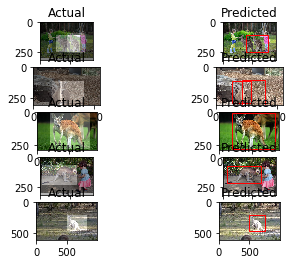

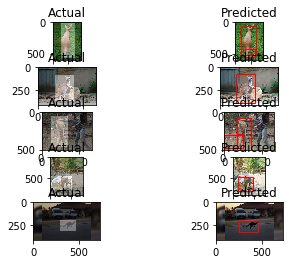

In [0]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)

# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)